# Baseline

## Load and prepare data

In [16]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch_geometric.data import Data, Batch
import tqdm

In [17]:
train_file = np.load('./cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)

train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


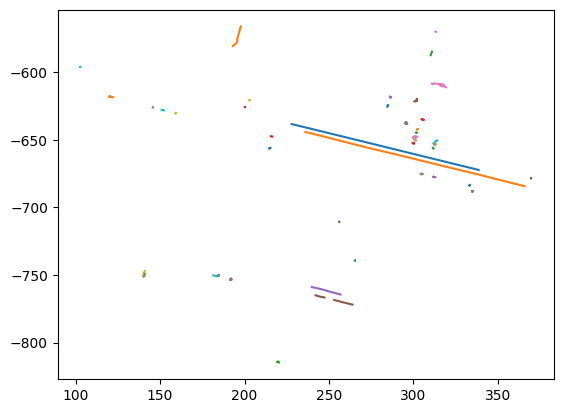

In [18]:
# plot one
import matplotlib.pyplot as plt

data_matrix = train_data[0]

for i in range(data_matrix.shape[0]):
    xs = data_matrix[i, :, 0]
    ys = data_matrix[i, :, 1]
    # trim all zeros
    xs = xs[xs != 0]
    ys = ys[ys != 0]
    # plot each line going from transparent to full
    plt.plot(xs, ys)

plt.show()

# Data Loaders

In [19]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

In [20]:
torch.manual_seed(251)
np.random.seed(42)

scale = 7.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


# LSTM

In [21]:
# Example of basic model that should work
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128, output_dim=60*2):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Add multi-layer prediction head for better results
        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(0.1)  # Add dropout for regularization
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        
        # Initialize weights properly
        for name, param in self.named_parameters():
            if 'weight' in name:
                nn.init.xavier_normal_(param)
            elif 'bias' in name:
                nn.init.constant_(param, 0.0)
        
    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :]  # Only consider ego agent (index 0)
        
        # Process through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Extract final hidden state
        features = lstm_out[:, -1, :]
        
        # Process through prediction head
        features = self.relu(self.fc1(features))
        features = self.dropout(features)
        out = self.fc2(features)
        
        # Reshape to (batch_size, 60, 2)
        return out.view(-1, 60, 2)

# Train

In [22]:
def train_improved_model(model, train_dataloader, val_dataloader, 
                         device, criterion=nn.MSELoss(), 
                         lr=0.001, epochs=100, patience=15):
    """
    Improved training function with better debugging and early stopping
    """
    # Initialize optimizer with smaller learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # Exponential decay scheduler
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)
    
    early_stopping_patience = patience
    best_val_loss = float('inf')
    no_improvement = 0
    
    # Save initial state for comparison
    initial_state_dict = {k: v.clone() for k, v in model.state_dict().items()}
    
    for epoch in tqdm.tqdm(range(epochs), desc="Epoch", unit="epoch"):
        # ---- Training ----
        model.train()
        train_loss = 0
        num_train_batches = 0
        
        for batch in train_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Check for NaN predictions
            if torch.isnan(pred).any():
                print(f"WARNING: NaN detected in predictions during training")
                continue
                
            loss = criterion(pred, y)
            
            # Check if loss is valid
            if torch.isnan(loss) or torch.isinf(loss):
                print(f"WARNING: Invalid loss value: {loss.item()}")
                continue
                
            optimizer.zero_grad()
            loss.backward()
            
            # More conservative gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            
            optimizer.step()
            train_loss += loss.item()
            num_train_batches += 1
        
        # Skip epoch if no valid batches
        if num_train_batches == 0:
            print("WARNING: No valid training batches in this epoch")
            continue
            
        train_loss /= num_train_batches
        
        # ---- Validation ----
        model.eval()
        val_loss = 0
        val_mae = 0
        val_mse = 0
        num_val_batches = 0
        
        # Sample predictions for debugging
        sample_input = None
        sample_pred = None
        sample_target = None
        
        with torch.no_grad():
            for batch_idx, batch in enumerate(val_dataloader):
                batch = batch.to(device)
                pred = model(batch)
                y = batch.y.view(batch.num_graphs, 60, 2)
                
                # Store sample for debugging
                if batch_idx == 0 and sample_input is None:
                    sample_input = batch.x[0].cpu().numpy()
                    sample_pred = pred[0].cpu().numpy()
                    sample_target = y[0].cpu().numpy()
                
                # Skip invalid predictions
                if torch.isnan(pred).any():
                    print(f"WARNING: NaN detected in predictions during validation")
                    continue
                    
                batch_loss = criterion(pred, y).item()
                val_loss += batch_loss
                
                # Unnormalize for real-world metrics
                pred_unnorm = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                y_unnorm = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                
                val_mae += nn.L1Loss()(pred_unnorm, y_unnorm).item()
                val_mse += nn.MSELoss()(pred_unnorm, y_unnorm).item()
                
                num_val_batches += 1
        
        # Skip epoch if no valid validation batches
        if num_val_batches == 0:
            print("WARNING: No valid validation batches in this epoch")
            continue
            
        val_loss /= num_val_batches
        val_mae /= num_val_batches
        val_mse /= num_val_batches
        
        # Update learning rate
        scheduler.step()
        
        # Print with more details
        tqdm.tqdm.write(
            f"Epoch {epoch:03d} | LR {optimizer.param_groups[0]['lr']:.6f} | "
            f"Train MSE {train_loss:.4f} | Val MSE {val_loss:.4f} | "
            f"Val MAE {val_mae:.4f} | Val MSE {val_mse:.4f}"
        )
        
        # Debug output - first 3 predictions vs targets
        if epoch % 5 == 0:
            tqdm.tqdm.write(f"Sample pred first 3 steps: {sample_pred[:3]}")
            tqdm.tqdm.write(f"Sample target first 3 steps: {sample_target[:3]}")
            
            # Check if model weights are changing
            if epoch > 0:
                weight_change = False
                for name, param in model.named_parameters():
                    if param.requires_grad:
                        initial_param = initial_state_dict[name]
                        if not torch.allclose(param, initial_param, rtol=1e-4):
                            weight_change = True
                            break
                if not weight_change:
                    tqdm.tqdm.write("WARNING: Model weights barely changing!")
        
        # Relaxed improvement criterion - consider any improvement
        if val_loss < best_val_loss:
            tqdm.tqdm.write(f"Validation improved: {best_val_loss:.6f} -> {val_loss:.6f}")
            best_val_loss = val_loss
            no_improvement = 0
            torch.save(model.state_dict(), "best_model.pt")
        else:
            no_improvement += 1
            if no_improvement >= early_stopping_patience:
                print(f"Early stopping after {epoch+1} epochs without improvement")
                break
    
    # Load best model before returning
    model.load_state_dict(torch.load("best_model.pt"))
    return model

In [23]:
# Example usage
def train_and_evaluate_model():
    # Create model
    model = SimpleLSTM(input_dim=6, hidden_dim=128)
    model = model.to(device)
    
    # Train with improved function
    train_improved_model(
        model=model,
        train_dataloader=train_dataloader,
        val_dataloader=val_dataloader,
        device=device,
        lr=0.0005,  # Lower learning rate
        patience=20  # More patience
    )
    
    # Evaluate
    model.eval()
    test_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            
            # Unnormalize
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            
            test_mse += nn.MSELoss()(pred, y).item()
    
    test_mse /= len(val_dataloader)
    print(f"Val MSE: {test_mse:.4f}")
    
    return model

train_and_evaluate_model()

Epoch:   0%|          | 0/100 [00:00<?, ?epoch/s]/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_49283/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_49283/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   1%|          | 1/100 [00:07<12:51,  7.80s/epoch]

Epoch 000 | LR 0.000475 | Train MSE 2.0975 | Val MSE 0.4853 | Val MAE 2.6188 | Val MSE 23.7802
Sample pred first 3 steps: [[ 0.01209358 -0.01262153]
 [ 0.01291927  0.04639293]
 [ 0.02713237 -0.03327122]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: inf -> 0.485311


Epoch:   2%|▏         | 2/100 [00:13<10:31,  6.45s/epoch]

Epoch 001 | LR 0.000451 | Train MSE 0.5095 | Val MSE 0.3435 | Val MAE 2.2203 | Val MSE 16.8302
Validation improved: 0.485311 -> 0.343474


Epoch:   3%|▎         | 3/100 [00:18<09:40,  5.99s/epoch]

Epoch 002 | LR 0.000429 | Train MSE 0.4210 | Val MSE 0.2989 | Val MAE 2.1143 | Val MSE 14.6454
Validation improved: 0.343474 -> 0.298887


Epoch:   4%|▍         | 4/100 [00:24<09:12,  5.76s/epoch]

Epoch 003 | LR 0.000407 | Train MSE 0.3824 | Val MSE 0.2871 | Val MAE 1.9051 | Val MSE 14.0668
Validation improved: 0.298887 -> 0.287077


Epoch:   5%|▌         | 5/100 [00:29<08:55,  5.64s/epoch]

Epoch 004 | LR 0.000387 | Train MSE 0.3542 | Val MSE 0.2838 | Val MAE 2.0263 | Val MSE 13.9060
Validation improved: 0.287077 -> 0.283797


Epoch:   5%|▌         | 5/100 [00:34<08:55,  5.64s/epoch]

Epoch 005 | LR 0.000368 | Train MSE 0.3319 | Val MSE 0.2854 | Val MAE 2.0671 | Val MSE 13.9865
Sample pred first 3 steps: [[-0.00465532 -0.01156954]
 [-0.01975883  0.00478906]
 [-0.00668545  0.02861509]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:   7%|▋         | 7/100 [00:40<08:38,  5.57s/epoch]

Epoch 006 | LR 0.000349 | Train MSE 0.3255 | Val MSE 0.2554 | Val MAE 1.8039 | Val MSE 12.5168
Validation improved: 0.283797 -> 0.255445


Epoch:   8%|▊         | 8/100 [00:46<08:27,  5.52s/epoch]

Epoch 007 | LR 0.000332 | Train MSE 0.3156 | Val MSE 0.2534 | Val MAE 1.8064 | Val MSE 12.4152
Validation improved: 0.255445 -> 0.253372


Epoch:   9%|▉         | 9/100 [00:51<08:18,  5.48s/epoch]

Epoch 008 | LR 0.000315 | Train MSE 0.3074 | Val MSE 0.2620 | Val MAE 1.8302 | Val MSE 12.8376


Epoch:  10%|█         | 10/100 [00:56<08:07,  5.41s/epoch]

Epoch 009 | LR 0.000299 | Train MSE 0.3019 | Val MSE 0.2558 | Val MAE 1.8044 | Val MSE 12.5354


Epoch:  11%|█         | 11/100 [01:02<08:13,  5.54s/epoch]

Epoch 010 | LR 0.000284 | Train MSE 0.2951 | Val MSE 0.2440 | Val MAE 1.7906 | Val MSE 11.9561
Sample pred first 3 steps: [[-0.00753415 -0.0026619 ]
 [-0.00682133  0.00198884]
 [-0.01065744 -0.00041776]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.253372 -> 0.244002


Epoch:  12%|█▏        | 12/100 [01:08<08:19,  5.68s/epoch]

Epoch 011 | LR 0.000270 | Train MSE 0.2853 | Val MSE 0.2553 | Val MAE 1.9067 | Val MSE 12.5088


Epoch:  13%|█▎        | 13/100 [01:14<08:14,  5.68s/epoch]

Epoch 012 | LR 0.000257 | Train MSE 0.2856 | Val MSE 0.2513 | Val MAE 1.8619 | Val MSE 12.3149


Epoch:  14%|█▍        | 14/100 [01:19<08:03,  5.62s/epoch]

Epoch 013 | LR 0.000244 | Train MSE 0.2873 | Val MSE 0.2210 | Val MAE 1.6777 | Val MSE 10.8309
Validation improved: 0.244002 -> 0.221039


Epoch:  15%|█▌        | 15/100 [01:25<07:53,  5.57s/epoch]

Epoch 014 | LR 0.000232 | Train MSE 0.2769 | Val MSE 0.2263 | Val MAE 1.7082 | Val MSE 11.0878


Epoch:  16%|█▌        | 16/100 [01:30<07:43,  5.52s/epoch]

Epoch 015 | LR 0.000220 | Train MSE 0.2749 | Val MSE 0.2322 | Val MAE 1.6776 | Val MSE 11.3776
Sample pred first 3 steps: [[-0.00194155  0.00254375]
 [-0.00441842  0.00250216]
 [-0.00413484  0.00437956]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  17%|█▋        | 17/100 [01:36<07:35,  5.49s/epoch]

Epoch 016 | LR 0.000209 | Train MSE 0.2718 | Val MSE 0.2226 | Val MAE 1.5841 | Val MSE 10.9076


Epoch:  18%|█▊        | 18/100 [01:41<07:25,  5.44s/epoch]

Epoch 017 | LR 0.000199 | Train MSE 0.2703 | Val MSE 0.2258 | Val MAE 1.6784 | Val MSE 11.0662


Epoch:  19%|█▉        | 19/100 [01:46<07:17,  5.40s/epoch]

Epoch 018 | LR 0.000189 | Train MSE 0.2644 | Val MSE 0.2196 | Val MAE 1.6222 | Val MSE 10.7622
Validation improved: 0.221039 -> 0.219638


Epoch:  20%|██        | 20/100 [01:52<07:15,  5.44s/epoch]

Epoch 019 | LR 0.000179 | Train MSE 0.2683 | Val MSE 0.2165 | Val MAE 1.6054 | Val MSE 10.6061
Validation improved: 0.219638 -> 0.216452


Epoch:  21%|██        | 21/100 [01:57<07:12,  5.48s/epoch]

Epoch 020 | LR 0.000170 | Train MSE 0.2633 | Val MSE 0.2193 | Val MAE 1.6683 | Val MSE 10.7443
Sample pred first 3 steps: [[-0.00059889  0.00083085]
 [-0.00028754  0.00123013]
 [-0.00060217  0.00011652]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  22%|██▏       | 22/100 [02:04<07:34,  5.82s/epoch]

Epoch 021 | LR 0.000162 | Train MSE 0.2626 | Val MSE 0.2193 | Val MAE 1.5854 | Val MSE 10.7438


Epoch:  23%|██▎       | 23/100 [02:09<07:19,  5.71s/epoch]

Epoch 022 | LR 0.000154 | Train MSE 0.2598 | Val MSE 0.2391 | Val MAE 1.7648 | Val MSE 11.7148


Epoch:  24%|██▍       | 24/100 [02:15<07:08,  5.64s/epoch]

Epoch 023 | LR 0.000146 | Train MSE 0.2572 | Val MSE 0.2162 | Val MAE 1.6073 | Val MSE 10.5962
Validation improved: 0.216452 -> 0.216249


Epoch:  25%|██▌       | 25/100 [02:20<07:02,  5.63s/epoch]

Epoch 024 | LR 0.000139 | Train MSE 0.2565 | Val MSE 0.2206 | Val MAE 1.6793 | Val MSE 10.8109


Epoch:  26%|██▌       | 26/100 [02:26<06:53,  5.58s/epoch]

Epoch 025 | LR 0.000132 | Train MSE 0.2541 | Val MSE 0.2159 | Val MAE 1.5720 | Val MSE 10.5777
Sample pred first 3 steps: [[0.00028644 0.00119208]
 [0.00076822 0.00099   ]
 [0.00202987 0.00042371]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.216249 -> 0.215872


Epoch:  27%|██▋       | 27/100 [02:31<06:47,  5.59s/epoch]

Epoch 026 | LR 0.000125 | Train MSE 0.2563 | Val MSE 0.2145 | Val MAE 1.6103 | Val MSE 10.5121
Validation improved: 0.215872 -> 0.214532


Epoch:  28%|██▊       | 28/100 [02:37<06:46,  5.64s/epoch]

Epoch 027 | LR 0.000119 | Train MSE 0.2513 | Val MSE 0.2140 | Val MAE 1.6081 | Val MSE 10.4842
Validation improved: 0.214532 -> 0.213964


Epoch:  29%|██▉       | 29/100 [02:43<06:37,  5.60s/epoch]

Epoch 028 | LR 0.000113 | Train MSE 0.2528 | Val MSE 0.2090 | Val MAE 1.5658 | Val MSE 10.2422
Validation improved: 0.213964 -> 0.209025


Epoch:  30%|███       | 30/100 [02:48<06:30,  5.58s/epoch]

Epoch 029 | LR 0.000107 | Train MSE 0.2482 | Val MSE 0.2098 | Val MAE 1.6054 | Val MSE 10.2795


Epoch:  31%|███       | 31/100 [02:54<06:26,  5.60s/epoch]

Epoch 030 | LR 0.000102 | Train MSE 0.2485 | Val MSE 0.2044 | Val MAE 1.5448 | Val MSE 10.0140
Sample pred first 3 steps: [[ 2.1166606e-03  6.9588609e-04]
 [ 5.0095120e-03  6.5138564e-05]
 [ 9.0878084e-03 -1.1274619e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.209025 -> 0.204367


Epoch:  32%|███▏      | 32/100 [02:59<06:19,  5.59s/epoch]

Epoch 031 | LR 0.000097 | Train MSE 0.2462 | Val MSE 0.2063 | Val MAE 1.5677 | Val MSE 10.1089


Epoch:  33%|███▎      | 33/100 [03:06<06:31,  5.85s/epoch]

Epoch 032 | LR 0.000092 | Train MSE 0.2421 | Val MSE 0.2101 | Val MAE 1.5570 | Val MSE 10.2942


Epoch:  34%|███▍      | 34/100 [03:11<06:19,  5.75s/epoch]

Epoch 033 | LR 0.000087 | Train MSE 0.2416 | Val MSE 0.2077 | Val MAE 1.5676 | Val MSE 10.1783


Epoch:  35%|███▌      | 35/100 [03:17<06:08,  5.67s/epoch]

Epoch 034 | LR 0.000083 | Train MSE 0.2433 | Val MSE 0.2102 | Val MAE 1.5446 | Val MSE 10.3013


Epoch:  36%|███▌      | 36/100 [03:22<05:59,  5.62s/epoch]

Epoch 035 | LR 0.000079 | Train MSE 0.2421 | Val MSE 0.1985 | Val MAE 1.4862 | Val MSE 9.7272
Sample pred first 3 steps: [[-0.00046698  0.0020055 ]
 [-0.00057977  0.00441941]
 [-0.00014407  0.00578259]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.204367 -> 0.198515


Epoch:  37%|███▋      | 37/100 [03:28<05:51,  5.58s/epoch]

Epoch 036 | LR 0.000075 | Train MSE 0.2417 | Val MSE 0.2002 | Val MAE 1.4902 | Val MSE 9.8074


Epoch:  38%|███▊      | 38/100 [03:34<05:46,  5.58s/epoch]

Epoch 037 | LR 0.000071 | Train MSE 0.2394 | Val MSE 0.1974 | Val MAE 1.5220 | Val MSE 9.6724
Validation improved: 0.198515 -> 0.197395


Epoch:  39%|███▉      | 39/100 [03:39<05:40,  5.58s/epoch]

Epoch 038 | LR 0.000068 | Train MSE 0.2416 | Val MSE 0.1990 | Val MAE 1.5117 | Val MSE 9.7517


Epoch:  40%|████      | 40/100 [03:45<05:32,  5.54s/epoch]

Epoch 039 | LR 0.000064 | Train MSE 0.2392 | Val MSE 0.1987 | Val MAE 1.4672 | Val MSE 9.7382


Epoch:  41%|████      | 41/100 [03:50<05:26,  5.53s/epoch]

Epoch 040 | LR 0.000061 | Train MSE 0.2364 | Val MSE 0.1998 | Val MAE 1.4836 | Val MSE 9.7878
Sample pred first 3 steps: [[-3.4020282e-05  1.3633168e-03]
 [ 3.6623701e-04  2.0969920e-03]
 [ 4.1724462e-04  2.6727454e-03]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  42%|████▏     | 42/100 [03:56<05:21,  5.54s/epoch]

Epoch 041 | LR 0.000058 | Train MSE 0.2388 | Val MSE 0.1956 | Val MAE 1.4668 | Val MSE 9.5848
Validation improved: 0.197395 -> 0.195608


Epoch:  43%|████▎     | 43/100 [04:02<05:23,  5.68s/epoch]

Epoch 042 | LR 0.000055 | Train MSE 0.2348 | Val MSE 0.2005 | Val MAE 1.5226 | Val MSE 9.8236


Epoch:  44%|████▍     | 44/100 [04:07<05:20,  5.73s/epoch]

Epoch 043 | LR 0.000052 | Train MSE 0.2354 | Val MSE 0.1974 | Val MAE 1.4877 | Val MSE 9.6711


Epoch:  45%|████▌     | 45/100 [04:13<05:11,  5.67s/epoch]

Epoch 044 | LR 0.000050 | Train MSE 0.2365 | Val MSE 0.1979 | Val MAE 1.5215 | Val MSE 9.6991


Epoch:  46%|████▌     | 46/100 [04:19<05:03,  5.63s/epoch]

Epoch 045 | LR 0.000047 | Train MSE 0.2351 | Val MSE 0.1951 | Val MAE 1.4449 | Val MSE 9.5575
Sample pred first 3 steps: [[ 0.00156909 -0.00062859]
 [ 0.00268569 -0.00034138]
 [ 0.00342022 -0.00055727]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.195608 -> 0.195051


Epoch:  47%|████▋     | 47/100 [04:24<04:58,  5.63s/epoch]

Epoch 046 | LR 0.000045 | Train MSE 0.2341 | Val MSE 0.1968 | Val MAE 1.4977 | Val MSE 9.6426


Epoch:  48%|████▊     | 48/100 [04:30<04:50,  5.59s/epoch]

Epoch 047 | LR 0.000043 | Train MSE 0.2346 | Val MSE 0.1976 | Val MAE 1.4750 | Val MSE 9.6827


Epoch:  49%|████▉     | 49/100 [04:35<04:46,  5.63s/epoch]

Epoch 048 | LR 0.000040 | Train MSE 0.2319 | Val MSE 0.1933 | Val MAE 1.4550 | Val MSE 9.4723
Validation improved: 0.195051 -> 0.193312


Epoch:  50%|█████     | 50/100 [04:41<04:41,  5.63s/epoch]

Epoch 049 | LR 0.000038 | Train MSE 0.2320 | Val MSE 0.1948 | Val MAE 1.4668 | Val MSE 9.5434


Epoch:  51%|█████     | 51/100 [04:46<04:33,  5.59s/epoch]

Epoch 050 | LR 0.000037 | Train MSE 0.2345 | Val MSE 0.2008 | Val MAE 1.5301 | Val MSE 9.8394
Sample pred first 3 steps: [[0.00014459 0.00090863]
 [0.0001398  0.00145131]
 [0.00012538 0.00116522]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  52%|█████▏    | 52/100 [04:52<04:34,  5.71s/epoch]

Epoch 051 | LR 0.000035 | Train MSE 0.2348 | Val MSE 0.1930 | Val MAE 1.4355 | Val MSE 9.4583
Validation improved: 0.193312 -> 0.193026


Epoch:  53%|█████▎    | 53/100 [04:59<04:37,  5.91s/epoch]

Epoch 052 | LR 0.000033 | Train MSE 0.2319 | Val MSE 0.1939 | Val MAE 1.4651 | Val MSE 9.5018


Epoch:  54%|█████▍    | 54/100 [05:06<04:43,  6.16s/epoch]

Epoch 053 | LR 0.000031 | Train MSE 0.2319 | Val MSE 0.1904 | Val MAE 1.4462 | Val MSE 9.3290
Validation improved: 0.193026 -> 0.190388


Epoch:  55%|█████▌    | 55/100 [05:12<04:43,  6.31s/epoch]

Epoch 054 | LR 0.000030 | Train MSE 0.2302 | Val MSE 0.1923 | Val MAE 1.4423 | Val MSE 9.4249


Epoch:  56%|█████▌    | 56/100 [05:19<04:41,  6.41s/epoch]

Epoch 055 | LR 0.000028 | Train MSE 0.2319 | Val MSE 0.1962 | Val MAE 1.5107 | Val MSE 9.6139
Sample pred first 3 steps: [[ 0.00014961  0.00124288]
 [-0.00066874  0.0026401 ]
 [-0.00137849  0.00336262]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  57%|█████▋    | 57/100 [05:25<04:35,  6.41s/epoch]

Epoch 056 | LR 0.000027 | Train MSE 0.2308 | Val MSE 0.1931 | Val MAE 1.4254 | Val MSE 9.4617


Epoch:  58%|█████▊    | 58/100 [05:31<04:20,  6.20s/epoch]

Epoch 057 | LR 0.000026 | Train MSE 0.2348 | Val MSE 0.1939 | Val MAE 1.4707 | Val MSE 9.5012


Epoch:  59%|█████▉    | 59/100 [05:37<04:12,  6.16s/epoch]

Epoch 058 | LR 0.000024 | Train MSE 0.2330 | Val MSE 0.1964 | Val MAE 1.4814 | Val MSE 9.6233


Epoch:  60%|██████    | 60/100 [05:42<03:56,  5.91s/epoch]

Epoch 059 | LR 0.000023 | Train MSE 0.2296 | Val MSE 0.1942 | Val MAE 1.4488 | Val MSE 9.5158


Epoch:  61%|██████    | 61/100 [05:48<03:46,  5.82s/epoch]

Epoch 060 | LR 0.000022 | Train MSE 0.2312 | Val MSE 0.1932 | Val MAE 1.4495 | Val MSE 9.4668
Sample pred first 3 steps: [[0.00052276 0.00063275]
 [0.00115241 0.00145085]
 [0.00142232 0.00218098]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  62%|██████▏   | 62/100 [05:54<03:42,  5.86s/epoch]

Epoch 061 | LR 0.000021 | Train MSE 0.2313 | Val MSE 0.1931 | Val MAE 1.4603 | Val MSE 9.4628


Epoch:  63%|██████▎   | 63/100 [05:59<03:32,  5.74s/epoch]

Epoch 062 | LR 0.000020 | Train MSE 0.2303 | Val MSE 0.1944 | Val MAE 1.4577 | Val MSE 9.5245


Epoch:  64%|██████▍   | 64/100 [06:06<03:32,  5.89s/epoch]

Epoch 063 | LR 0.000019 | Train MSE 0.2292 | Val MSE 0.1957 | Val MAE 1.4580 | Val MSE 9.5909


Epoch:  65%|██████▌   | 65/100 [06:11<03:20,  5.73s/epoch]

Epoch 064 | LR 0.000018 | Train MSE 0.2261 | Val MSE 0.1935 | Val MAE 1.4622 | Val MSE 9.4806


Epoch:  66%|██████▌   | 66/100 [06:17<03:21,  5.93s/epoch]

Epoch 065 | LR 0.000017 | Train MSE 0.2301 | Val MSE 0.1904 | Val MAE 1.4238 | Val MSE 9.3292
Sample pred first 3 steps: [[0.00022188 0.00021891]
 [0.00082344 0.00117678]
 [0.00095497 0.0018518 ]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  67%|██████▋   | 67/100 [06:24<03:23,  6.16s/epoch]

Epoch 066 | LR 0.000016 | Train MSE 0.2282 | Val MSE 0.1923 | Val MAE 1.4367 | Val MSE 9.4205


Epoch:  68%|██████▊   | 68/100 [06:30<03:15,  6.10s/epoch]

Epoch 067 | LR 0.000015 | Train MSE 0.2287 | Val MSE 0.1910 | Val MAE 1.4416 | Val MSE 9.3587


Epoch:  69%|██████▉   | 69/100 [06:35<03:00,  5.82s/epoch]

Epoch 068 | LR 0.000015 | Train MSE 0.2293 | Val MSE 0.1911 | Val MAE 1.4406 | Val MSE 9.3632


Epoch:  70%|███████   | 70/100 [06:40<02:48,  5.61s/epoch]

Epoch 069 | LR 0.000014 | Train MSE 0.2291 | Val MSE 0.1902 | Val MAE 1.4228 | Val MSE 9.3192
Validation improved: 0.190388 -> 0.190187


Epoch:  71%|███████   | 71/100 [06:46<02:47,  5.76s/epoch]

Epoch 070 | LR 0.000013 | Train MSE 0.2305 | Val MSE 0.1909 | Val MAE 1.4486 | Val MSE 9.3533
Sample pred first 3 steps: [[ 1.0117429e-03 -2.9377104e-04]
 [ 2.3042827e-03 -2.6410166e-04]
 [ 3.4879798e-03 -1.2179837e-05]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  72%|███████▏  | 72/100 [06:52<02:36,  5.59s/epoch]

Epoch 071 | LR 0.000012 | Train MSE 0.2307 | Val MSE 0.1903 | Val MAE 1.4425 | Val MSE 9.3270


Epoch:  73%|███████▎  | 73/100 [06:57<02:27,  5.47s/epoch]

Epoch 072 | LR 0.000012 | Train MSE 0.2281 | Val MSE 0.1898 | Val MAE 1.4353 | Val MSE 9.3016
Validation improved: 0.190187 -> 0.189829


Epoch:  74%|███████▍  | 74/100 [07:03<02:25,  5.58s/epoch]

Epoch 073 | LR 0.000011 | Train MSE 0.2288 | Val MSE 0.1892 | Val MAE 1.4159 | Val MSE 9.2710
Validation improved: 0.189829 -> 0.189205


Epoch:  75%|███████▌  | 75/100 [07:08<02:20,  5.62s/epoch]

Epoch 074 | LR 0.000011 | Train MSE 0.2284 | Val MSE 0.1898 | Val MAE 1.4308 | Val MSE 9.3011


Epoch:  76%|███████▌  | 76/100 [07:14<02:11,  5.50s/epoch]

Epoch 075 | LR 0.000010 | Train MSE 0.2306 | Val MSE 0.1911 | Val MAE 1.4381 | Val MSE 9.3623
Sample pred first 3 steps: [[ 0.00021788  0.00051399]
 [ 0.00014078  0.0006593 ]
 [-0.00010479  0.00079909]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  77%|███████▋  | 77/100 [07:19<02:04,  5.42s/epoch]

Epoch 076 | LR 0.000010 | Train MSE 0.2289 | Val MSE 0.1906 | Val MAE 1.4292 | Val MSE 9.3384


Epoch:  78%|███████▊  | 78/100 [07:24<01:57,  5.35s/epoch]

Epoch 077 | LR 0.000009 | Train MSE 0.2275 | Val MSE 0.1893 | Val MAE 1.4198 | Val MSE 9.2768


Epoch:  79%|███████▉  | 79/100 [07:29<01:50,  5.26s/epoch]

Epoch 078 | LR 0.000009 | Train MSE 0.2290 | Val MSE 0.1900 | Val MAE 1.4205 | Val MSE 9.3108


Epoch:  80%|████████  | 80/100 [07:34<01:44,  5.22s/epoch]

Epoch 079 | LR 0.000008 | Train MSE 0.2278 | Val MSE 0.1891 | Val MAE 1.4298 | Val MSE 9.2661
Validation improved: 0.189205 -> 0.189104


Epoch:  81%|████████  | 81/100 [07:40<01:39,  5.24s/epoch]

Epoch 080 | LR 0.000008 | Train MSE 0.2305 | Val MSE 0.1889 | Val MAE 1.4110 | Val MSE 9.2552
Sample pred first 3 steps: [[0.00039363 0.00011941]
 [0.00083877 0.00046721]
 [0.00132791 0.00084169]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]
Validation improved: 0.189104 -> 0.188882


Epoch:  82%|████████▏ | 82/100 [07:45<01:35,  5.31s/epoch]

Epoch 081 | LR 0.000007 | Train MSE 0.2268 | Val MSE 0.1893 | Val MAE 1.4237 | Val MSE 9.2777


Epoch:  83%|████████▎ | 83/100 [07:50<01:29,  5.26s/epoch]

Epoch 082 | LR 0.000007 | Train MSE 0.2285 | Val MSE 0.1907 | Val MAE 1.4355 | Val MSE 9.3441


Epoch:  84%|████████▍ | 84/100 [07:55<01:23,  5.21s/epoch]

Epoch 083 | LR 0.000007 | Train MSE 0.2284 | Val MSE 0.1902 | Val MAE 1.4181 | Val MSE 9.3220


Epoch:  85%|████████▌ | 85/100 [08:01<01:19,  5.28s/epoch]

Epoch 084 | LR 0.000006 | Train MSE 0.2270 | Val MSE 0.1890 | Val MAE 1.4040 | Val MSE 9.2617


Epoch:  86%|████████▌ | 86/100 [08:06<01:15,  5.37s/epoch]

Epoch 085 | LR 0.000006 | Train MSE 0.2277 | Val MSE 0.1894 | Val MAE 1.4119 | Val MSE 9.2826
Sample pred first 3 steps: [[0.00089275 0.00020996]
 [0.00140089 0.0002802 ]
 [0.001843   0.00043372]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  87%|████████▋ | 87/100 [08:12<01:09,  5.36s/epoch]

Epoch 086 | LR 0.000006 | Train MSE 0.2277 | Val MSE 0.1894 | Val MAE 1.4231 | Val MSE 9.2823


Epoch:  88%|████████▊ | 88/100 [08:17<01:03,  5.32s/epoch]

Epoch 087 | LR 0.000005 | Train MSE 0.2262 | Val MSE 0.1895 | Val MAE 1.4267 | Val MSE 9.2860


Epoch:  89%|████████▉ | 89/100 [08:22<00:58,  5.32s/epoch]

Epoch 088 | LR 0.000005 | Train MSE 0.2252 | Val MSE 0.1904 | Val MAE 1.4262 | Val MSE 9.3310


Epoch:  90%|█████████ | 90/100 [08:27<00:52,  5.25s/epoch]

Epoch 089 | LR 0.000005 | Train MSE 0.2273 | Val MSE 0.1885 | Val MAE 1.4067 | Val MSE 9.2364
Validation improved: 0.188882 -> 0.188499


Epoch:  91%|█████████ | 91/100 [08:32<00:47,  5.26s/epoch]

Epoch 090 | LR 0.000005 | Train MSE 0.2268 | Val MSE 0.1896 | Val MAE 1.4193 | Val MSE 9.2906
Sample pred first 3 steps: [[0.00051478 0.00018548]
 [0.00122563 0.00048334]
 [0.00194724 0.00077321]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  92%|█████████▏| 92/100 [08:38<00:41,  5.21s/epoch]

Epoch 091 | LR 0.000004 | Train MSE 0.2299 | Val MSE 0.1894 | Val MAE 1.4148 | Val MSE 9.2789


Epoch:  93%|█████████▎| 93/100 [08:43<00:36,  5.17s/epoch]

Epoch 092 | LR 0.000004 | Train MSE 0.2266 | Val MSE 0.1895 | Val MAE 1.4239 | Val MSE 9.2837


Epoch:  94%|█████████▍| 94/100 [08:48<00:31,  5.19s/epoch]

Epoch 093 | LR 0.000004 | Train MSE 0.2285 | Val MSE 0.1896 | Val MAE 1.4133 | Val MSE 9.2908


Epoch:  95%|█████████▌| 95/100 [08:53<00:25,  5.16s/epoch]

Epoch 094 | LR 0.000004 | Train MSE 0.2286 | Val MSE 0.1889 | Val MAE 1.4126 | Val MSE 9.2584


Epoch:  96%|█████████▌| 96/100 [08:59<00:21,  5.36s/epoch]

Epoch 095 | LR 0.000004 | Train MSE 0.2257 | Val MSE 0.1890 | Val MAE 1.4068 | Val MSE 9.2600
Sample pred first 3 steps: [[0.00069465 0.00020624]
 [0.00137581 0.00053267]
 [0.00202738 0.00088248]]
Sample target first 3 steps: [[3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]
 [3.2984033e-06 6.9473140e-06]]


Epoch:  97%|█████████▋| 97/100 [09:05<00:17,  5.73s/epoch]

Epoch 096 | LR 0.000003 | Train MSE 0.2299 | Val MSE 0.1900 | Val MAE 1.4172 | Val MSE 9.3078


Epoch:  98%|█████████▊| 98/100 [09:11<00:11,  5.70s/epoch]

Epoch 097 | LR 0.000003 | Train MSE 0.2278 | Val MSE 0.1891 | Val MAE 1.4097 | Val MSE 9.2653


Epoch:  99%|█████████▉| 99/100 [09:17<00:05,  5.83s/epoch]

Epoch 098 | LR 0.000003 | Train MSE 0.2265 | Val MSE 0.1888 | Val MAE 1.4090 | Val MSE 9.2523


Epoch: 100%|██████████| 100/100 [09:23<00:00,  5.63s/epoch]
/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_49283/1114377084.py:150: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experim

Epoch 099 | LR 0.000003 | Train MSE 0.2276 | Val MSE 0.1898 | Val MAE 1.4183 | Val MSE 9.3011
Val MSE: 9.2364


SimpleLSTM(
  (lstm): LSTM(6, 128, batch_first=True)
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=120, bias=True)
)

# Final Pred

In [26]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
model = SimpleLSTM().to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers
# criterion = nn.MSELoss()

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission_lstm_simple_auto2.csv', index=True)

/var/folders/w3/lr66s56958q3881y1btpylth0000gn/T/ipykernel_49283/1294397202.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  best_model = torch.load("best_model.pt")
